# CNN - Melanoma Melignant or Benign - Keerthana Sivasubramaniam

    Skin cancer is the most prevalent type of cancer. Melanoma, specifically, is responsible for 75% of skin cancer deaths, despite being the least common skin cancer. The American Cancer Society estimates over 100,000 new melanoma cases will be diagnosed in 2020. It's also expected that almost 7,000 people will die from the disease. As with other cancers, early and accurate detection—potentially aided by data science—can make treatment more effective.

    Currently, dermatologists evaluate every one of a patient's moles to identify outlier lesions or “ugly ducklings” that are most likely to be melanoma. Existing AI approaches have not adequately considered this clinical frame of reference. Dermatologists could enhance their diagnostic accuracy if detection algorithms take into account “contextual” images within the same patient to determine which images represent a melanoma. If successful, classifiers would be more accurate and could better support dermatological clinic work.

### The below model predicts a binary target for each image. The model predicts the probability (floating point) between 0.0 and 1.0 that the lesion in the image is malignant (the target). In the training data, train.csv, the value 0 denotes benign, and 1 indicates malignant.

In [74]:
'''Importing libraries'''

import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf
import random
import os
import seaborn as sns


In [76]:
train_df = pd.read_csv('/home/ranjithramesh/Downloads/keerthana/ADS_project/train.csv')
test_df = pd.read_csv('/home/ranjithramesh/Downloads/keerthana/ADS_project/test.csv')
image_train_path = '/home/ranjithramesh/Downloads/keerthana/jpeg/train/'

### Cleaning and removing duplicates records if any!

In [77]:
print(pd.isnull(train_df).sum())
print(train_df.shape)

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64
(33126, 8)


In [78]:
print(pd.isnull(test_df).sum())
print(test_df.shape)

image_name                         0
patient_id                         0
sex                                0
age_approx                         0
anatom_site_general_challenge    351
dtype: int64
(10982, 5)


#### Drop the duplicated rows

In [79]:
train_df = train_df.drop_duplicates()
print(train_df.shape)

(33126, 8)


In [80]:
test_df = test_df.drop_duplicates()
print(test_df.shape)

(10982, 5)


### Reading the train csv file and splitting the malignant and benign data

In [81]:
malignant = train_df[train_df['benign_malignant'] == 'malignant']
benign = train_df[train_df['benign_malignant'] == 'benign']

In [82]:
malignant.shape

(584, 8)

In [83]:
malignant.head(3)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1


In [84]:
benign.shape

(32542, 8)

In [85]:
benign.head(3)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0


In [ ]:
'''Taking the malignant data frame which consists the malignant data and taking the image_name/id from it'''
'''Checking whether all the corresponding malignant images from the jpeg/train folder exists'''
'''Copying and renaming all the malignant images to another folder'''

import os.path
from os import path

malignant_img = malignant['image_name'].values

count = 0

for i in malignant_img:
    imgs =  i + '.jpg'
    mal_img = image_train_path + imgs
    #print(mal_img)
    
    if os.path.exists(image_train_path + imgs): 
        #print("exits")
        my_dest = "malignant" + str(count) + ".jpg"
        my_source = mal_img
        my_dest = "/home/ranjithramesh/Downloads/keerthana/ADS_project/train/" + my_dest
        
        os.rename(my_source,my_dest)
        count +=1
        
    else:
        print("nope")

In [ ]:
'''Taking the benign data frame which consists the benign data and taking the image_name/id from it'''
'''Checking whether all the corresponding benign images from the jpeg/train folder exists'''
'''Copying and renaming all the benign images to another folder'''

import os.path
from os import path

benign_img = benign['image_name'].values

count = 0

for i in benign_img:
    imgs =  i + '.jpg'
    b_img = image_train_path + imgs

    if os.path.exists(image_train_path + imgs):
        
        my_dest = "benign" + str(count) + ".jpg"
        my_source = b_img
        my_dest = "/home/ranjithramesh/Downloads/keerthana/ADS_project/train/" + my_dest
        
        os.rename(my_source,my_dest)
        count +=1

In [2]:
'''Defining constants'''

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
'''Prepare training data'''

filenames = os.listdir("/home/ranjithramesh/Downloads/keerthana/ADS_project/train/")
categories = []
for filename in filenames:
    
    if 'malignant' in filename:
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head(3)

,filename,category
0,benign4429.jpg,0
1,benign20131.jpg,0
2,benign6625.jpg,0


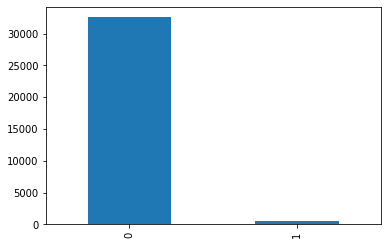

In [6]:
'''Total count of malignant and benign data'''

df['category'].value_counts().plot.bar()

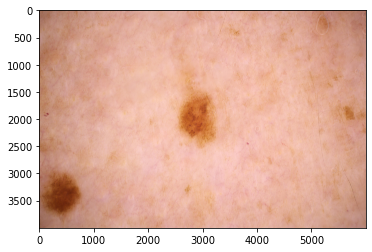

In [75]:
'''Sample images'''

sample = random.choice(filenames)
image = load_img("/home/ranjithramesh/Downloads/keerthana/ADS_project/train/"+sample)
plt.imshow(image)


In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [9]:
'''Prevent from over fitting we will stop the learning after 10 epochs'''

earlystop = EarlyStopping(patience=10)

In [10]:
'''Reduces the learning rate when then accuracy not increase for 2 steps'''

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [11]:
callbacks = [earlystop, learning_rate_reduction]

In [12]:
'''Imagenerator will convert it one-hot encoding and we will convert 1 to malignant and 0 to benign'''

df["category"] = df["category"].replace({0: 'benign', 1: 'malignant'}) 

In [13]:
'''Splits the train data into train(80%) and validation(20%)'''

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

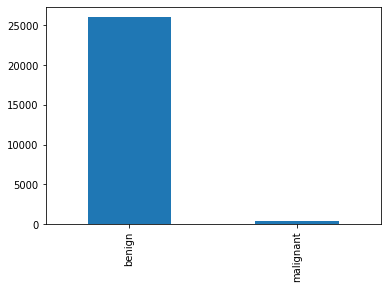

In [16]:
'''Shows the number of records for each category in the train data'''

train_df['category'].value_counts().plot.bar()

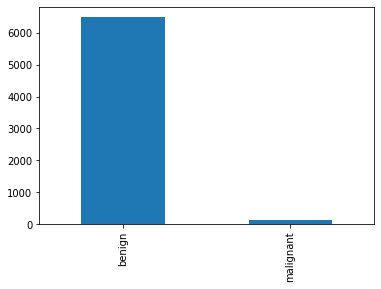

In [17]:
'''Shows the number of records for each category in the validation data'''

validate_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [19]:
'''Rescale and reshape the images in the training dataset'''

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/home/ranjithramesh/Downloads/keerthana/ADS_project/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 26500 validated image filenames belonging to 2 classes.


In [20]:
'''Rescale and reshape the images in the validation dataset'''

= ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/home/ranjithramesh/Downloads/keerthana/ADS_project/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 6625 validated image filenames belonging to 2 classes.


In [22]:
'''Fitting the model'''

epochs=3 if FAST_RUN else 5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/5
1766/1766 [==============================] - 5120s 3s/step - loss: 0.1301 - accuracy: 0.9737 - val_loss: 0.1657 - val_accuracy: 0.9799
Epoch 2/5
1766/1766 [==============================] - 5109s 3s/step - loss: 0.1104 - accuracy: 0.9803 - val_loss: 0.1173 - val_accuracy: 0.9799
Epoch 3/5
1766/1766 [==============================] - 5118s 3s/step - loss: 0.1108 - accuracy: 0.9817 - val_loss: 0.1432 - val_accuracy: 0.9794
Epoch 4/5
1766/1766 [==============================] - 5105s 3s/step - loss: 0.1104 - accuracy: 0.9811 - val_loss: 0.1514 - val_accuracy: 0.9799
Epoch 5/5
1766/1766 [==============================] - 5124s 3s/step - loss: 0.1152 - accuracy: 0.9803 - val_loss: 0.1872 - val_accuracy: 0.9790


In [23]:
'''Saving the model'''

model.save_weights("model.h7")

In [86]:
'''Listing out the test files'''

test_filenames = os.listdir("/home/ranjithramesh/Downloads/keerthana/ADS_project/jpeg/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [87]:
'''Rescaling and reshaping the test images'''

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/ranjithramesh/Downloads/keerthana/ADS_project/jpeg/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 10982 validated image filenames.


In [88]:
'''Predicting the test images'''

predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [89]:
'''Prediction will come with probability of each category.
   We pick the category that have the highest probability with numpy average max'''

test_df['category'] = np.argmax(predict, axis=-1)

In [90]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [91]:
'''Map the result back to malignant as 1 and benign as 0'''

test_df['category'] = test_df['category'].replace({ 'benign': 0, 'malignant': 1 })

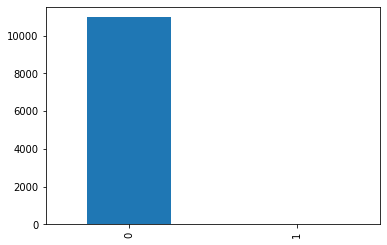

In [92]:
test_df['category'].value_counts().plot.bar()

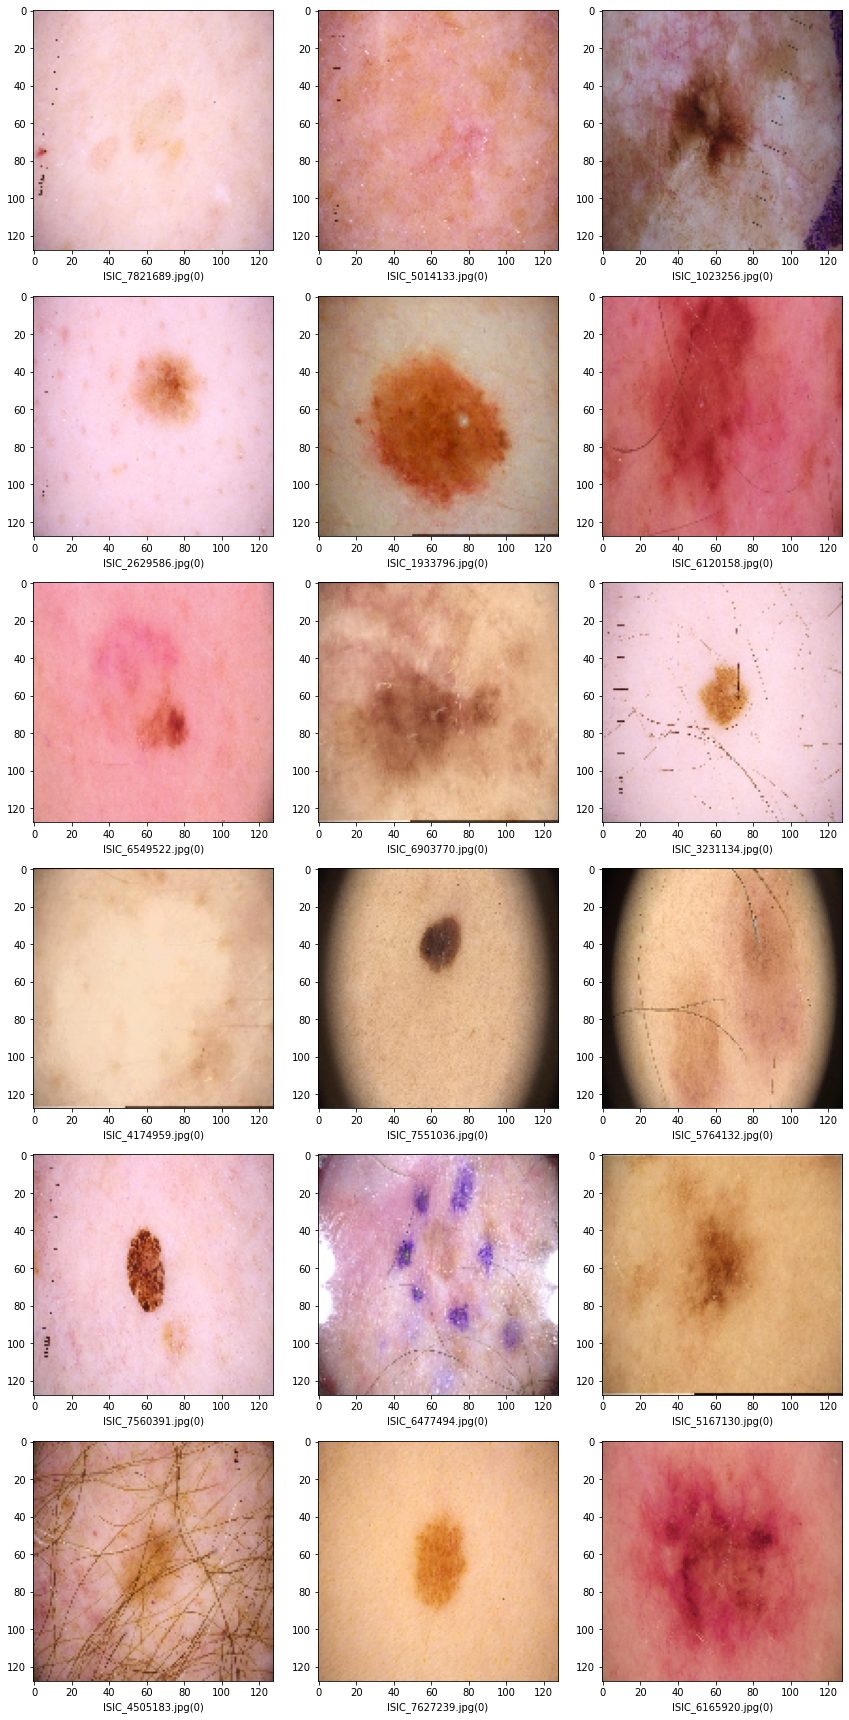

In [93]:
'''Samples display of test images'''

sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/home/ranjithramesh/Downloads/keerthana/ADS_project/jpeg/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [94]:
'''Copy everything with the image filenames with the target 0 or 1'''

submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)